In [138]:
!pip install opencv-python
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install pillow
!pip install torchvision


   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.6 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.6 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 3.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.8/204.1 MB 4.8 MB/s eta 0:00:43
   ---------------------------------------- 2.1/204.1 MB 5.9 MB/s eta 0:00:35
    --------------------------------------- 3.4/204.1 MB 5.8 MB/s eta 0:00:35
    --------------------------------------- 4.5/204.1 MB 6.0 MB/s eta 0:00:34
    --------------------------------------- 4.7/204.1 MB 4.8 MB/s eta 0:00:42
   - -------------------------------------- 6.0/204.1 MB 5.4 MB/s eta 0:00:37
   - -------------------------------------- 7.1/204.1 MB 4.9 MB/s eta 0:00:41
   - -------------------------------------- 8.1/204.1 MB 5.1 MB/s eta 0:00:39
   -- ---------

# Resizing the images:
Why resizing?
Origional images resolution might be very large, sometimes 1024x 1024. This might lead to high memory usage and longer computations.
Ideally, we can use varying sized images if we can spend high computation power and willing to adjust the architecture of CNN, adapting to different images.Sometimes, decreasing the resolution also helps from overfitting.
224X224 image size provides a good balance between maintaining resolution(with image details) and computational cost.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [9]:
import os
import cv2
from PIL import Image
import torchvision
# Garbage collector
import gc
gc.collect()


0

IOError happens when the file that we passed in as argument, does not exist or as a different name or the file location path is incorrect

PIL.Image.open(imagepath) creates an Image object, which holds reference to Image data. So the image's meta data is not fully loaded into the memory immediately. Inorder to read the data we have to use Image.load() function
https://pillow.readthedocs.io/en/stable/reference/Image.html

PIL.Image.resize(Imagepath) creates an resized copy of the image. For RGB mode, the default resampling method is BICUBIC interpolation.
https://pillow.readthedocs.io/en/stable/reference/Image.html

transforms.ToTensor():Converts the PIL image or nd array to Tensor inthe form( no.of channels, height_image, width_image)
 Tensor is the primary data structure used for computations in neural networks.
 https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html
 Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8
 
 transforms.Normalize: Normalize a tensor image with mean and  std. This transform doesnt support PIL image.
 Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e., output[channel] = (input[channel] - mean[channel]) / std[channel].
 https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html

 RandomResizedCrop:
classtorchvision.transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=InterpolationMode.BILINEAR, antialias: Optional[bool] = True)

Crop a random portion of image and resize it to a given size.
The cropping scale by default is (0.08,1.0) and resizes to (size,size).
https://pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html

RandomHorizontal Flip:
classtorchvision.transforms.RandomHorizontalFlip(p=0.5)
Flip the image horizontally with the given probability


transforms.RandomRotation(30):Rotate the image by angle. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions.

transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2):
Randomly change the brightness, contrast, saturation and hue of an image. If the image is torch Tensor, it is expected to have […, 1 or 3, H, W] shape, where … means an arbitrary number of leading dimensions. If img is PIL Image, mode “1”, “I”, “F” and modes with transparency (alpha channel) are not supported
https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html



Setting a seed would allow the program to be more reproducible. Setting the seed ensures that data augmentation techniques like RandoRotation, RandomHorizontalFlip, ColorJitter same augmentations are applied to images.

random.seed(): Ensures that Python's random module, which is used by some transformations like RandomHorizontalFlip, is seeded.

np.random.seed(): Ensures that any NumPy-based randomness is consistent.

torch.manual_seed(): Ensures that PyTorch uses the same random state for CPU-based operations.

torch.cuda.manual_seed(): Ensures that GPU-based operations are also deterministic if CUDA is used.

 Optional
torch.backends.cudnn.deterministic: Enforces deterministic behavior for certain convolution operations in PyTorch

Where should we place the seed?
If we want to make sure that random augmentations are reproducible for dataset or training augments are reproducible for the dataset, passing the seed to the class or function responsible for data augmentation is important. This allows transformations to be tied directly to the seed in a controlled manner.





In [17]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision.utils import save_image

class CustomImageDataset(Dataset):
    def __init__(self, images_path, fixed_size,transform=transforms.Compose([transforms.ToTensor()]),
                 augment_data=False,random_seed=42):
        
        self.images_path = images_path
        self.fixed_size=fixed_size
        self.transform = transform
        self.augment_data=augment_data
        self.classes = os.listdir(images_path)  
        self.image_paths = []
        self.random_seed=random_seed

        # Setting the random seed to make random operations more reproducible while data augmentation, cpu operations
        random.seed(self.random_seed) #  random module makes RandomHorizontalFlip,RandomRotation more reproducible
        np.random.seed(self.random_seed)
        torch.manual_seed(self.random_seed) # Sets the random seed for Pytorch CPU operations
        torch.cuda.manual_seed(self.random_seed) # Sets the random seed for Pytorch single GPU operations)
        torch.cuda.manual_seed_all(self.random_seed) # Sets the random seed for all GPUs in case of multi-GPU setup
        
        # Creating a list of image paths and corresponding labels
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(images_path, class_name)
            if os.path.isdir(class_path):
                print(f"Scanning through {class_name} images.......")
                for filename in os.listdir(class_path):                              
                    image_path = os.path.join(class_path, filename) # Add the file name to the class_path
                    #Checking the image path is a file(not directory) and 
                    #Adding the image_path to the image_paths list
                    if os.path.isfile(image_path):
                        self.image_paths.append((image_path, class_idx))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path, class_idx = self.image_paths[idx]

        # Loading each image and converting to 'RGB' format
        image = Image.open(image_path).convert('RGB')

        # resizing the every image to get into a fixed size
        image = image.resize(self.fixed_size)

        # Applying the transformations
        if self.augment_data:
            augmented_image=self.transform(image)

            # Saves the augmented PIL image back to class path based on class index
            transformed_image_path=self.save_transformed_image(augmented_image,image_path,class_idx)

            # Adding the transformed image path to original paths present in image_paths
            self.image_paths.append((transformed_image_path, class_idx))
            
            return augmented_image,class_idx

        else:
            # Converts just to tensor and return for non-data augmented images
            image = self.transform(image)
            
            return image, class_idx
    
    def save_transformed_image(self, image_tensor, original_image_path,class_idx):
        """
        Function: Saves the transformed images through data augmentation to the respective
                    class folder.
        """
        class_name=self.classes[class_idx]
        class_path=os.path.join(self.images_path,class_name)

        # Path for the transformed image. Transforms to'transformed_341.jpg' for the filename with'341.jpg' original image
        transformed_filename=f"transformed_{os.path.basename(original_image_path)}"

        # Saving the image to the class folder
        save_path=os.path.join(class_path,transformed_filename)
        
        # Converting the tensor back to PIL image
        save_image(image_tensor,save_path)

        return save_path




In [14]:
def compute_class_stats(dataloader, dataset):
    class_stats = {}
    # Creating a global dictionary to store all statistics (mean, std, max, min)
    global_dict_stats= {
        "mean": torch.zeros(3),
        "std": torch.zeros(3),
        "max": torch.zeros(3),
        "min": torch.ones(3) * float('inf')
    }
    total_classes=len(dataset.classes)

    for batch_images, labels in dataloader:
        # Iterate over each image in the batch
        for batch_idx in range(batch_images.size(0)):
            image = batch_images[batch_idx]  # Image (3, 256, 256)
            label = labels[batch_idx].item()  
            
            # Creating a dictionary to access properties of the image in the class using class index.
            if label not in class_stats:
                class_stats[label] = {
                    "num_images": 0,
                    "height": image.size(1),
                    "width": image.size(2),
                    "sum_redpixels":0,
                    "sum_greenpixels":0,
                    "sum_bluepixels":0,
                    "mean_redpixels":0,
                    "mean_greenpixels":0,
                    "mean_bluepixels":0,
                    "sum_redpixels_sq": 0,   
                    "sum_greenpixels_sq": 0, 
                    "sum_bluepixels_sq": 0
                }
            # Counting number of images per class
            class_stats[label]["num_images"] += 1

            # Upadating the sum of pixels and squares of along each channel
            for idx, channel in enumerate(['redpixels', 'greenpixels', 'bluepixels']):
                class_stats[label][f"sum_{channel}"] += image[idx].sum()
                class_stats[label][f"sum_{channel}_sq"] += (image[idx] ** 2).sum()

                # Updating the global max and min for each channel
                global_dict_stats["max"][idx] = max(global_dict_stats["max"][idx], image[idx].max())
                global_dict_stats["min"][idx] = min(global_dict_stats["min"][idx], image[idx].min())

    # Creating a class_dict dictionary to access image properties of class through class name
    class_dict_stats={}
    
    #Computing the means and standard deviation for each class channel and also global mean and standard deviation
    for class_idx, stats in class_stats.items():
        class_name=dataset.classes[class_idx] 
        # Computing the mean and std along each channel of R,G,B
        for idx, channel in enumerate(['redpixels', 'greenpixels', 'bluepixels']):
            stats[f"mean_{channel}"]= stats[f"sum_{channel}"] / (stats["num_images"]  * stats["height"] * stats["width"])
            variance = (stats[f"sum_{channel}_sq"] / (stats["num_images"]  * stats["height"] * stats["width"])) - (stats[f"mean_{channel}"] ** 2)
            stats[f"std_{channel}"] = torch.sqrt(variance)

            # Updates the mean and standard deviation across all channels (R,G,B)
            global_dict_stats["mean"][idx] += stats[f"mean_{channel}"]
            global_dict_stats["std"][idx] += stats[f"std_{channel}"]
        
        # Assigning the image properties based on class 
        class_dict_stats[class_name]=stats

    # Computing the global mean and std for each channel(R,G,B) in the entire dataset
    global_dict_stats["mean"] /= total_classes
    global_dict_stats["std"] /= total_classes
  
    return class_dict_stats,global_dict_stats

In [ ]:
def plot_number_of_images(class_dict,save_title="barplot_number_of_images_per_class"):
    fig,axis=plt.subplots(figsize=(12,8))
    # Collecting the number of images in each class
    num_images=[class_dict[class_name]["num_images"] for class_name in class_dict]

    # Plotting number of images in each class
    axis.bar(class_dict.keys(),num_images)

    # Labelling the bars with number of images
    for idx, value in enumerate(num_images):
        axis.text(idx, value + 3, str(value), ha='center', va='bottom', fontsize=10)

    # Labelling the axis
    axis.set(xlabel="class",
            ylabel="number of images",
            title="Number of images per class")

    dir_path=os.path.join(os.getcwd(),"..","plots")
    image_path=os.path.join(dir_path,f"{save_title}.png")

    # Creating the images directory if the directory path doesnt exist
    os.makedirs(dir_path, exist_ok=True)    

    # saves the plot at the path
    plt.savefig(image_path)
    print(f"Saved the number of images per class plot at {image_path}\n")


# In main script:

Scanning through bike images.......
Scanning through bottle images.......
Scanning through chair images.......
Scanning through cup images.......
Scanning through fork images.......
Scanning through knife images.......
Scanning through plant images.......
Scanning through shoe images.......
Scanning through spoon images.......
Scanning through t-shirt images.......
Started loading images to compute image properties for original data
Completed computing image properties for original data.
    Saved the number of images per class plot at c:\Users\saiye\Documents\Scientific_computing_project\Notebook\..\plots\Original_datasest_number_of_images_per_class.png
Scanning through bike images.......
Scanning through bottle images.......
Scanning through chair images.......
Scanning through cup images.......
Scanning through fork images.......
Scanning through knife images.......
Scanning through plant images.......
Scanning through shoe images.......
Scanning through spoon images.......
Scanning

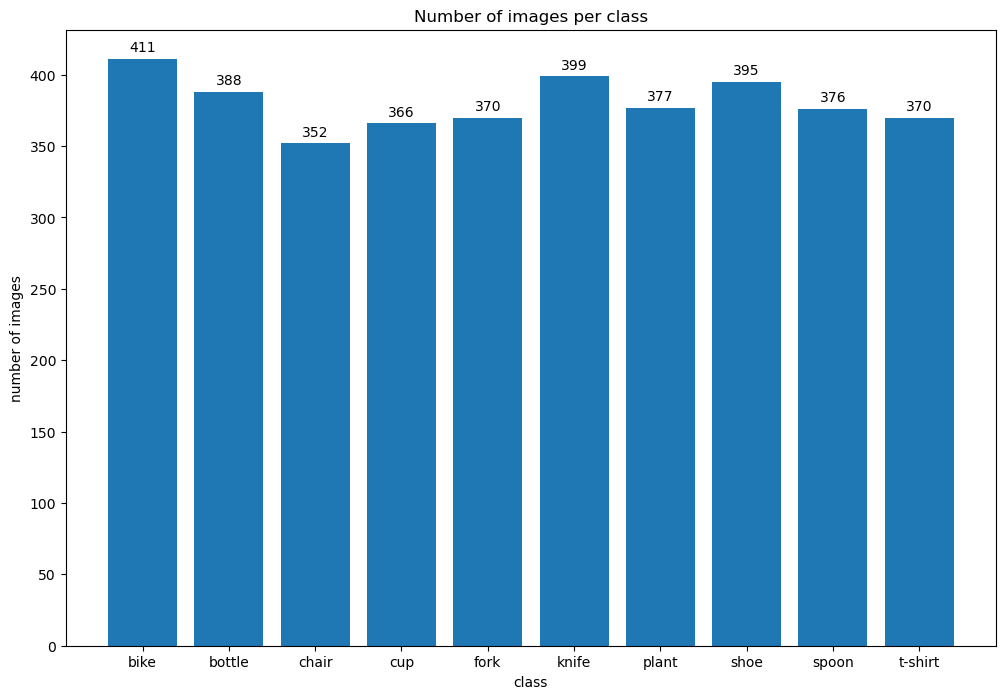

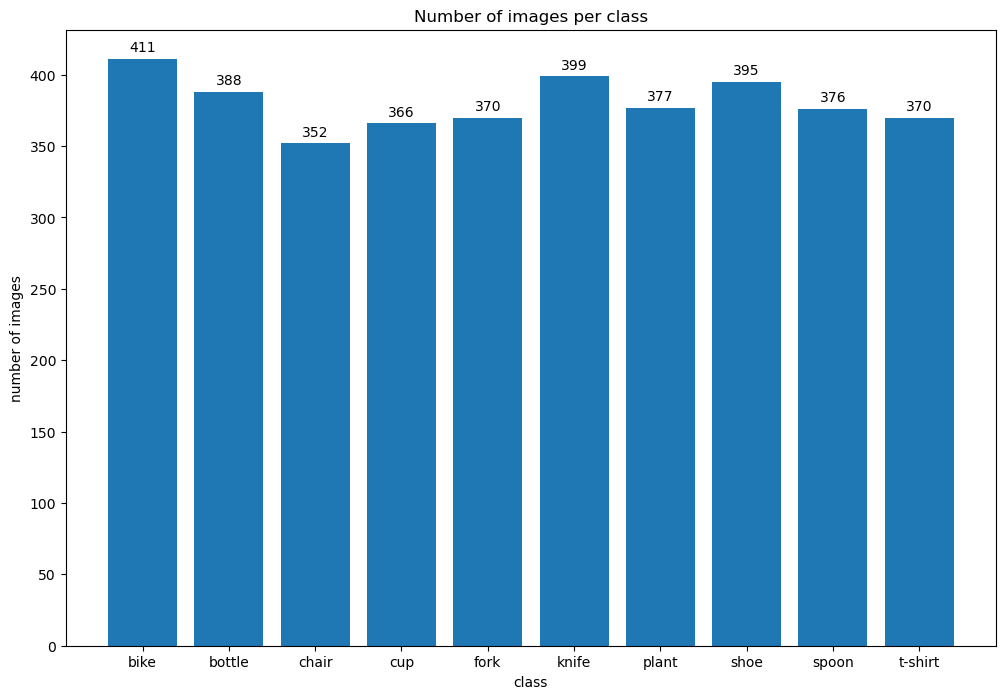

In [19]:
curr_dir=os.getcwd()

# Computing the image properties based on class and global properties(before normalization and data augmentation)
transformed_data_class1 = CustomImageDataset(
    images_path=os.path.join(curr_dir,"..","data_copy"),
    fixed_size=(224,224))

batch_data_loader1 = DataLoader(transformed_data_class1, batch_size=32, shuffle=False, num_workers=0)

print ("Started loading images to compute image properties for original data")

class_dict1,global_stats1 = compute_class_stats(batch_data_loader1, transformed_data_class1)
print("Completed computing image properties for original data.\n")

plot_number_of_images(class_dict1,save_title="Original_datasest_number_of_images_per_class")


# Computing the image properties based on class and global properties(after normalization and data augmentation)
# transforms normalized global mean and standard deviation for R,G,B channels
transforms2 = transforms.Compose(
    [transforms.RandomResizedCrop(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  
     transforms.ToTensor(),
     transforms.Normalize(global_stats1["mean"].tolist(), global_stats1["std"].tolist())
    ])

transformed_data_class2 = CustomImageDataset(
    images_path=os.path.join(curr_dir,"..","data_copy"),
    fixed_size=(224,224),
    transform=transforms2,
    augment_data=True)

print("Data augmentation Completed. The database has been augmented")
batch_data_loader2 = DataLoader(transformed_data_class2, batch_size=32, shuffle=False, num_workers=0)

print ("    Started loading images to compute image properties for transformed data ")

# Computing the image properties based on class and global properties(after normalization and data augmentation)
class_dict2,global_stats2 = compute_class_stats(batch_data_loader2, transformed_data_class2)

print("Completed computing image properties for transformed data.\n")

plot_number_of_images(class_dict1,save_title="Augmented_datasest_number_of_images_per_class")


In [20]:
class_dict2.keys()

dict_keys(['bike', 'bottle', 'chair', 'cup', 'fork', 'knife', 'plant', 'shoe', 'spoon', 't-shirt'])

In [21]:
class_dict1.keys()

dict_keys(['bike', 'bottle', 'chair', 'cup', 'fork', 'knife', 'plant', 'shoe', 'spoon', 't-shirt'])

In [22]:
global_stats1 # mean,std before normalization(just converted to Tensor)

{'mean': tensor([0.5285, 0.4851, 0.4376]),
 'std': tensor([0.2285, 0.2215, 0.2254]),
 'max': tensor([1., 1., 1.]),
 'min': tensor([0., 0., 0.])}

In [23]:
global_stats2 # mean and std after normalization

{'mean': tensor([-0.3293, -0.2855, -0.2123]),
 'std': tensor([1.1543, 1.1620, 1.0960]),
 'max': tensor([2.0630, 2.3247, 2.4956]),
 'min': tensor([-2.3127, -2.1900, -1.9414])}

## Visualizing the images

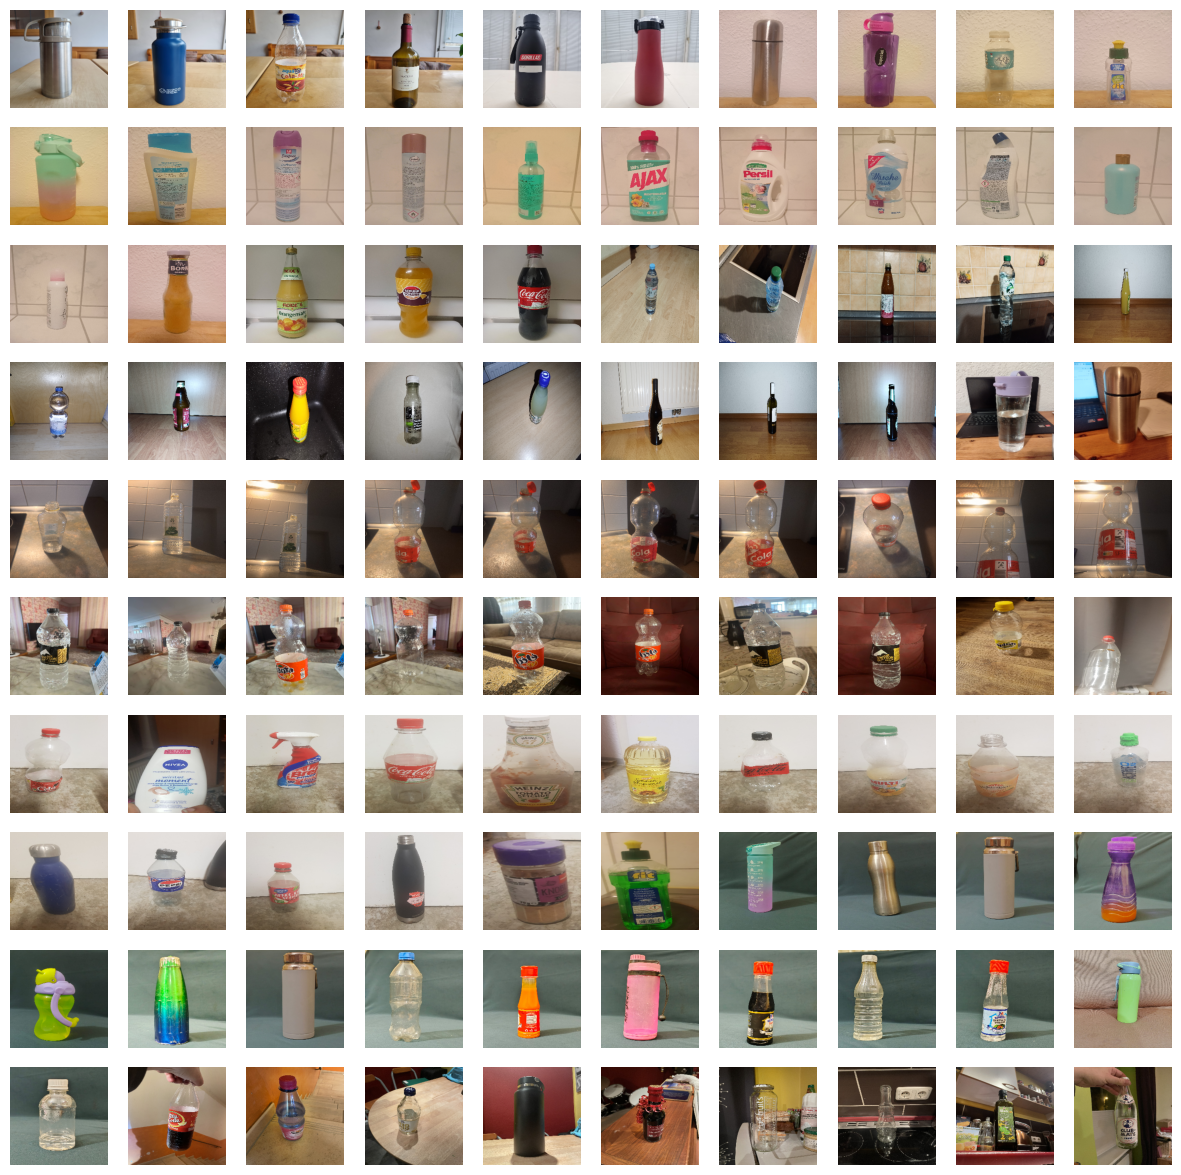

In [124]:
def visualize_class(label="chair",n_rows=10,n_cols=10,figsize=(15,15),**kwargs):
    class_images=class_dict[label]
    fig,axis=plt.subplots(n_rows,n_cols,figsize=figsize,**kwargs)
    for img,axis in zip(range(len(class_images)),axis.flatten()):
        axis.imshow(cv2.cvtColor(class_images[img],cv2.COLOR_BGR2RGB))
        axis.axis("off")
    plt.show()
visualize_class(label="bottle")